# Assignment 4

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data

In [3]:
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.fashion_mnist.load_data()

# Look at Data/Review Data

In [4]:
x_train[0].shape

(28, 28)

In [5]:
x_train.shape

(60000, 28, 28)

## Visualize (2 points) 

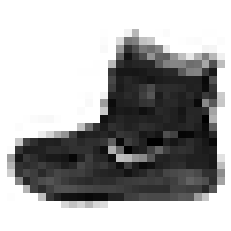

In [6]:
plt.imshow(x_train[0], cmap="binary")
plt.axis('off')
plt.show()

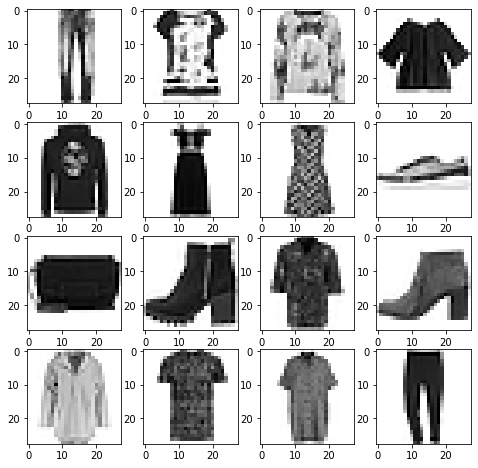

In [7]:
np.random.seed(42)
fig = plt.figure(figsize=(8,8))

for i in range(4):
    for j in range(4):
        ax = fig.add_subplot(4, 4, i * 4 + j + 1)
        rand_img = x_train[np.random.randint(0, x_train.shape[0])]
        ax.imshow(rand_img, cmap = 'binary')
plt.show()

## Normalize Images (divide through by max pixel intensity), 2 points

In [8]:
X_valid, X_train = x_train[:5000] / 255., x_train[5000:] / 255.
Y_valid, Y_train = y_train[:5000], y_train[5000:]
X_test = x_test / 255.

#Here I am normalizing the images and creating validation data to be used later. 

# MLP 

First develop an MLP model. Since the images are represented by 2D matrices, it will be necessary to reshape each image to
a 1D vector (so, overall, the dataset is of size (len(data), 28*28). An example is shown in notebook 8, where the autoencoder was used to process image data.

**Reshape the images for use with a standard MLP (rather than a Convolutuional Neural Network) (2 points)**

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
#The Flatten layer will convert each image input into a 1D array

## Build MLP Model (4 points)

In [10]:
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
#Finish with softmax activation for multiclass- classification.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [13]:
mymodel = model.fit(X_train, Y_train, epochs=30,
                    validation_data=(X_valid, Y_valid))

Epoch 1/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7177 - accuracy: 0.7625 - val_loss: 0.5210 - val_accuracy: 0.8226
Epoch 2/30
1719/1719 [==============================] - 2s 939us/step - loss: 0.4860 - accuracy: 0.8299 - val_loss: 0.4536 - val_accuracy: 0.8404
Epoch 3/30
1719/1719 [==============================] - 2s 997us/step - loss: 0.4398 - accuracy: 0.8450 - val_loss: 0.4354 - val_accuracy: 0.8498
Epoch 4/30
1719/1719 [==============================] - 2s 964us/step - loss: 0.4127 - accuracy: 0.8550 - val_loss: 0.4229 - val_accuracy: 0.8518
Epoch 5/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3922 - accuracy: 0.8609 - val_loss: 0.3847 - val_accuracy: 0.8686
Epoch 6/30
1719/1719 [==============================] - 2s 918us/step - loss: 0.3758 - accuracy: 0.8668 - val_loss: 0.3675 - val_accuracy: 0.8742
Epoch 7/30
1719/1719 [==============================] - 2s 948us/step - loss: 0.3627 - accuracy: 0.8712 - val_loss: 0.3649 - val

### Plot Training/Validation Performance Curves (2  points)

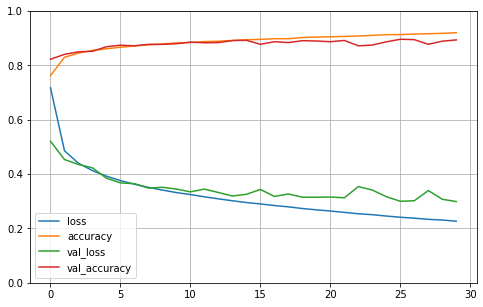

In [14]:
pd.DataFrame(mymodel.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

**Interpret Plot? (1 point)**

We see that training accuracy and validation accuracy are slowly increasing meaning the model is learning. 
We also see that the training set accuracy is very close to our validation accuracy suggesting that there is not too much overfitting.

In [15]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 648us/step - loss: 0.3278 - accuracy: 0.8835


[0.32780560851097107, 0.8834999799728394]

We see our accuracy score of .88 with no tuning.

## Try to Improve the Model (2 pojnts)


I am going to attempt to improve my model by Hypertuning it using a Keras provided tuner.
I will start by using the model builder function to create a hypermodel.

In [16]:
!pip install -q -U keras-tuner
import keras_tuner as kt

In [17]:
def model_builder(hp):
  model3 = keras.Sequential()
  model3.add(keras.layers.Flatten(input_shape=(28, 28)))

  #Here I am looking for optimal number of units in the first Dense layer between 32-512.
  optimal_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model3.add(keras.layers.Dense(units=optimal_units, activation='relu'))
  model3.add(keras.layers.Dense(10))

#The learning rate is said to be one of the most important Hyperparamenters so I am tuning it here.
  optimal_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model3.compile(optimizer=keras.optimizers.SGD(learning_rate=optimal_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model3

In [18]:
tuned = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     seed = 42,
                     directory='my_dir1',
                     project_name='mlptuned')

INFO:tensorflow:Reloading Oracle from existing project my_dir1\mlptuned\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir1\mlptuned\tuner0.json


In [19]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#Early stopping after val loss stabilizes for 5 epochs 

In [20]:
tuned.search(X_train, Y_train, epochs=30, validation_data=(X_valid, Y_valid), callbacks=[stop_early])

INFO:tensorflow:Oracle triggered exit


In [21]:
best_hps=tuned.get_best_hyperparameters(num_trials=1)[0]

In [22]:
print(f"""
The optimal number of units in the first layer is {best_hps.get('units')} 
and the optimal learning rate is {best_hps.get('learning_rate')}.
""")


The optimal number of units in the first layer is 224 
and the optimal learning rate is 0.01.



In [23]:
tunedmodel = tuned.hypermodel.build(best_hps)
history = tunedmodel.fit(X_train, Y_train, epochs=30, validation_data=(X_valid, Y_valid))
#Here I am retaining my model with the optimal first layer units and the optimal learning rate

Epoch 1/30
1719/1719 [==============================] - 1s 780us/step - loss: 0.7495 - accuracy: 0.7534 - val_loss: 0.5454 - val_accuracy: 0.8150
Epoch 2/30
1719/1719 [==============================] - 1s 749us/step - loss: 0.5199 - accuracy: 0.8232 - val_loss: 0.4771 - val_accuracy: 0.8442
Epoch 3/30
1719/1719 [==============================] - 1s 767us/step - loss: 0.4718 - accuracy: 0.8377 - val_loss: 0.4503 - val_accuracy: 0.8462
Epoch 4/30
1719/1719 [==============================] - 1s 753us/step - loss: 0.4467 - accuracy: 0.8457 - val_loss: 0.4383 - val_accuracy: 0.8530
Epoch 5/30
1719/1719 [==============================] - 1s 751us/step - loss: 0.4286 - accuracy: 0.8518 - val_loss: 0.4163 - val_accuracy: 0.8562
Epoch 6/30
1719/1719 [==============================] - 1s 742us/step - loss: 0.4137 - accuracy: 0.8574 - val_loss: 0.4209 - val_accuracy: 0.8572
Epoch 7/30
1719/1719 [==============================] - 1s 746us/step - loss: 0.4016 - accuracy: 0.8603 - val_loss: 0.4034 -

In [24]:
tunedmodel.evaluate(X_test, y_test)

313/313 [==============================] - 0s 564us/step - loss: 0.3615 - accuracy: 0.8730


[0.3615117371082306, 0.8730000257492065]

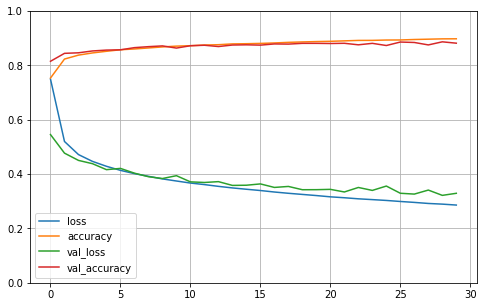

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Once again see our accuracy and validation accuracy run very similar meaning it appears we have limited overfitting. 
Even after tuning our model to various hyperparameters, we can see that our metrics are almost the same. 
Although we could do more adjustments on our MLP, it may be better to create a CNN which may be able to generalize better

# Build a CNN Model (5 points)

Now, see if using image specific layers,for instance, the Conv2D, improve the classification performance

In [26]:
from functools import partial

#My initial CNN model included MaxPooling and Dropout which performed well. 
#To get a good baseline, I am creating a very barebones CNN with some layers altered/removed.
#I also reduce the number of filters to keep computation time reasonable. 

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")
model1 = keras.models.Sequential([
    DefaultConv2D(filters=16, kernel_size=7, input_shape=[28, 28, 1]),
    #keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=32),
    #DefaultConv2D(filters=128),
    #keras.layers.MaxPooling2D(pool_size=2),
    #DefaultConv2D(filters=256),
    #DefaultConv2D(filters=256),
    #keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [27]:
model1.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
mymodel1 = model1.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))
score = model1.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 68s 39ms/step - loss: 0.3780 - accuracy: 0.8635 - val_loss: 0.2741 - val_accuracy: 0.8980
Epoch 2/10
1719/1719 [==============================] - 67s 39ms/step - loss: 0.2425 - accuracy: 0.9096 - val_loss: 0.2432 - val_accuracy: 0.9096
Epoch 3/10
1719/1719 [==============================] - 68s 39ms/step - loss: 0.1834 - accuracy: 0.9317 - val_loss: 0.2504 - val_accuracy: 0.9154
Epoch 4/10
1719/1719 [==============================] - 68s 39ms/step - loss: 0.1370 - accuracy: 0.9482 - val_loss: 0.2565 - val_accuracy: 0.9136
Epoch 5/10
1719/1719 [==============================] - 72s 42ms/step - loss: 0.1011 - accuracy: 0.9631 - val_loss: 0.2467 - val_accuracy: 0.9228
Epoch 6/10
1719/1719 [==============================] - 78s 45ms/step - loss: 0.0732 - accuracy: 0.9729 - val_loss: 0.3717 - val_accuracy: 0.9080
Epoch 7/10
1719/1719 [==============================] - 72s 42ms/step - loss: 0.0587 - accuracy: 0.9786 - val_loss: 0.3613 -

In [28]:
score

[0.4940580427646637, 0.9150999784469604]

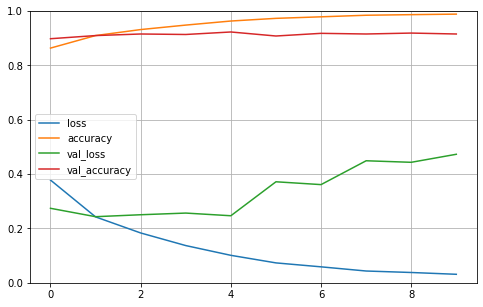

In [29]:
pd.DataFrame(mymodel1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Despite performing well on accuracy, we see a large increase in loss with our barebones CNN model.
We can see the effect of removing those different forms of regularization.

In [30]:
#I will now run the full model 
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")
model2 = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
#Stacking two layers with smaller kernals reduces parameters and computations
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [31]:
model2.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
mymodel2 = model2.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))
score = model2.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 117s 67ms/step - loss: 0.6923 - accuracy: 0.7566 - val_loss: 0.3538 - val_accuracy: 0.8780
Epoch 2/10
1719/1719 [==============================] - 115s 67ms/step - loss: 0.3980 - accuracy: 0.8655 - val_loss: 0.2890 - val_accuracy: 0.8908
Epoch 3/10
1719/1719 [==============================] - 115s 67ms/step - loss: 0.3435 - accuracy: 0.8819 - val_loss: 0.2585 - val_accuracy: 0.8976
Epoch 4/10
1719/1719 [==============================] - 115s 67ms/step - loss: 0.3139 - accuracy: 0.8943 - val_loss: 0.2477 - val_accuracy: 0.9118
Epoch 5/10
1719/1719 [==============================] - 115s 67ms/step - loss: 0.2880 - accuracy: 0.9000 - val_loss: 0.2429 - val_accuracy: 0.9068
Epoch 6/10
1719/1719 [==============================] - 115s 67ms/step - loss: 0.2642 - accuracy: 0.9091 - val_loss: 0.2949 - val_accuracy: 0.9010
Epoch 7/10
1719/1719 [==============================] - 115s 67ms/step - loss: 0.2531 - accuracy: 0.9116 - val_loss: 0

In [32]:
score

[0.2834358811378479, 0.9103000164031982]

### Plot Training/Validation Performance Curves (2 points)

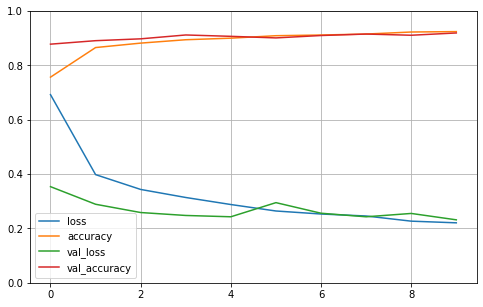

In [33]:
pd.DataFrame(mymodel2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

As we can see, the validation loss starts to go higher.
This might suggest we have an issue with the validation data since training loss looks normal.

In [34]:
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")
modela = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
#Stacking two layers with smaller kernals reduces parameters and computations
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [35]:
modela.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
mymodela = modela.fit(X_train, Y_train, epochs=10, validation_split=.2)
#I am going to use validation_split instead of validation_accuracy 
#to try and address validation loss increase.
score = modela.evaluate(X_test, y_test)

Epoch 1/10
1375/1375 [==============================] - 101s 72ms/step - loss: 0.7946 - accuracy: 0.7077 - val_loss: 0.4010 - val_accuracy: 0.8454
Epoch 2/10
1375/1375 [==============================] - 102s 74ms/step - loss: 0.4383 - accuracy: 0.8502 - val_loss: 0.3231 - val_accuracy: 0.8818
Epoch 3/10
1375/1375 [==============================] - 103s 75ms/step - loss: 0.3689 - accuracy: 0.8752 - val_loss: 0.3021 - val_accuracy: 0.8885
Epoch 4/10
1375/1375 [==============================] - 104s 76ms/step - loss: 0.3322 - accuracy: 0.8865 - val_loss: 0.2841 - val_accuracy: 0.8976
Epoch 5/10
1375/1375 [==============================] - 27018s 20s/step - loss: 0.3013 - accuracy: 0.8972 - val_loss: 0.2902 - val_accuracy: 0.8957
Epoch 6/10
1375/1375 [==============================] - 87s 63ms/step - loss: 0.2747 - accuracy: 0.9075 - val_loss: 0.2667 - val_accuracy: 0.9046
Epoch 7/10
1375/1375 [==============================] - 89s 65ms/step - loss: 0.2569 - accuracy: 0.9120 - val_loss: 0.

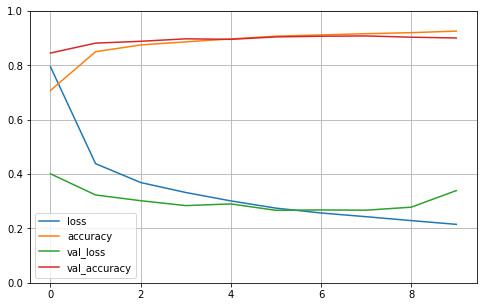

In [36]:
pd.DataFrame(mymodela.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

**Interpret plot? (1 point)**

In this plot we can see that our Convolutional neural network converges much faster than our MLP. Where we gave our MLP 30 epochs to learn, our CNN is getting better perfomance in less than 10 epochs. The CONV2D Layers do a great job at improving our model and speeding up the process. We can also see the benefits of including regularizing techniques like dropout and max pooling. 





## Try to Improve the Model (2 points)

Hyperparameter searching with CNN's can get quite time consuming.
Since we did grid search for the MLP I will try a few different approaches to try to improve my CNN model. 

In [37]:
#This model is replacing every single RELU Activation with a LeakyReLU Activation.
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.2), padding="SAME")
model3 = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation= tf.keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [38]:
model3.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
mymodel3 = model3.fit(X_train, Y_train, epochs=10, validation_split=.2)
score = model3.evaluate(X_test, y_test)

Epoch 1/10
1375/1375 [==============================] - 92s 66ms/step - loss: 0.6248 - accuracy: 0.7829 - val_loss: 0.3547 - val_accuracy: 0.8664
Epoch 2/10
1375/1375 [==============================] - 91s 66ms/step - loss: 29.3528 - accuracy: 0.7076 - val_loss: 0.7019 - val_accuracy: 0.7495
Epoch 3/10
1375/1375 [==============================] - 95s 69ms/step - loss: 0.7528 - accuracy: 0.7365 - val_loss: 0.4607 - val_accuracy: 0.8325
Epoch 4/10
1375/1375 [==============================] - 94s 69ms/step - loss: 0.5553 - accuracy: 0.8039 - val_loss: 0.3744 - val_accuracy: 0.8601
Epoch 5/10
1375/1375 [==============================] - 98s 71ms/step - loss: 0.4819 - accuracy: 0.8326 - val_loss: 0.3522 - val_accuracy: 0.8705
Epoch 6/10
1375/1375 [==============================] - 98s 71ms/step - loss: 0.4138 - accuracy: 0.8554 - val_loss: 0.3172 - val_accuracy: 0.8815
Epoch 7/10
1375/1375 [==============================] - 98s 71ms/step - loss: 2.4994 - accuracy: 0.7645 - val_loss: 0.3885 

In [39]:
print(score)

[0.3007643222808838, 0.8881999850273132]


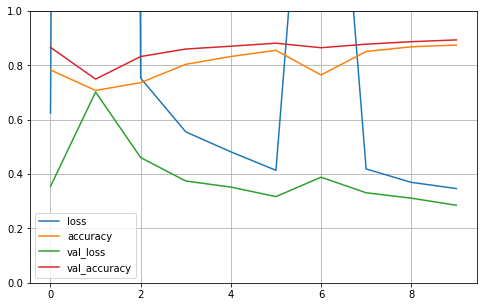

In [40]:
pd.DataFrame(mymodel3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [41]:
#This model only replaces RELU with LeakyReLU in the fully connected layers
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")
model4 = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation= tf.keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [42]:
model4.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
mymodel4 = model4.fit(X_train, Y_train, epochs=10, validation_split=.2)
score = model4.evaluate(X_test, y_test)

Epoch 1/10
1375/1375 [==============================] - 107s 78ms/step - loss: 0.6122 - accuracy: 0.7822 - val_loss: 0.3584 - val_accuracy: 0.8674
Epoch 2/10
1375/1375 [==============================] - 108s 79ms/step - loss: 0.3613 - accuracy: 0.8736 - val_loss: 0.2989 - val_accuracy: 0.8845
Epoch 3/10
1375/1375 [==============================] - 96s 70ms/step - loss: 0.3073 - accuracy: 0.8889 - val_loss: 0.2771 - val_accuracy: 0.8989
Epoch 4/10
1375/1375 [==============================] - 96s 70ms/step - loss: 0.2768 - accuracy: 0.9020 - val_loss: 0.2630 - val_accuracy: 0.9049
Epoch 5/10
1375/1375 [==============================] - 97s 71ms/step - loss: 0.2500 - accuracy: 0.9098 - val_loss: 0.2591 - val_accuracy: 0.9061
Epoch 6/10
1375/1375 [==============================] - 96s 70ms/step - loss: 0.2302 - accuracy: 0.9167 - val_loss: 0.2586 - val_accuracy: 0.9085
Epoch 7/10
1375/1375 [==============================] - 93s 68ms/step - loss: 0.2149 - accuracy: 0.9234 - val_loss: 0.2448

In [43]:
score

[0.3139127194881439, 0.9107000231742859]

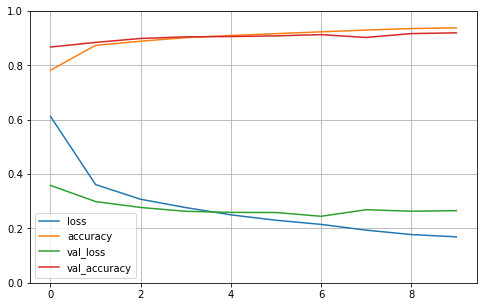

In [44]:
pd.DataFrame(mymodel4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [45]:
#This is the previous model with added Batch Normalization 
model5 = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    #keras.layers.BatchNormalization(),
    #Batch Normalizing the first layer may not be necssesary since we standardized the inputs.
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation= tf.keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [46]:
model5.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
mymodel5 = model5.fit(X_train, Y_train, epochs=10, validation_split=.2)
score = model5.evaluate(X_test, y_test)

Epoch 1/10
1375/1375 [==============================] - 98s 70ms/step - loss: 0.6309 - accuracy: 0.7860 - val_loss: 0.3703 - val_accuracy: 0.8672
Epoch 2/10
1375/1375 [==============================] - 99s 72ms/step - loss: 0.3944 - accuracy: 0.8660 - val_loss: 0.3073 - val_accuracy: 0.8858
Epoch 3/10
1375/1375 [==============================] - 100s 73ms/step - loss: 0.3374 - accuracy: 0.8861 - val_loss: 0.2710 - val_accuracy: 0.9022
Epoch 4/10
1375/1375 [==============================] - 103s 75ms/step - loss: 0.3017 - accuracy: 0.8953 - val_loss: 0.2651 - val_accuracy: 0.8975
Epoch 5/10
1375/1375 [==============================] - 102s 74ms/step - loss: 0.2746 - accuracy: 0.9040 - val_loss: 0.2380 - val_accuracy: 0.9119
Epoch 6/10
1375/1375 [==============================] - 100s 73ms/step - loss: 0.2511 - accuracy: 0.9130 - val_loss: 0.2587 - val_accuracy: 0.9062
Epoch 7/10
1375/1375 [==============================] - 97s 71ms/step - loss: 0.2309 - accuracy: 0.9204 - val_loss: 0.22

In [47]:
score

[0.25922712683677673, 0.907800018787384]

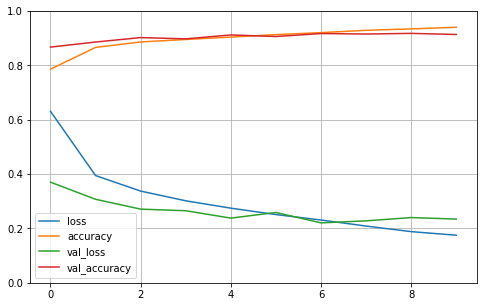

In [48]:
pd.DataFrame(mymodel5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [49]:
#Model with batch normalization after input layer.
model6 = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation= tf.keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [50]:
model6.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
mymodel6 = model6.fit(X_train, Y_train, epochs=10, validation_split=.2)
score = model6.evaluate(X_test, y_test)

Epoch 1/10
1375/1375 [==============================] - 114s 82ms/step - loss: 0.6105 - accuracy: 0.7956 - val_loss: 0.4060 - val_accuracy: 0.8499
Epoch 2/10
1375/1375 [==============================] - 110s 80ms/step - loss: 0.3891 - accuracy: 0.8670 - val_loss: 0.2960 - val_accuracy: 0.8878
Epoch 3/10
1375/1375 [==============================] - 117s 85ms/step - loss: 0.3303 - accuracy: 0.8883 - val_loss: 0.2765 - val_accuracy: 0.8944
Epoch 4/10
1375/1375 [==============================] - 118s 86ms/step - loss: 0.2977 - accuracy: 0.8978 - val_loss: 0.3009 - val_accuracy: 0.8891
Epoch 5/10
1375/1375 [==============================] - 123s 90ms/step - loss: 0.2723 - accuracy: 0.9078 - val_loss: 0.2440 - val_accuracy: 0.9105
Epoch 6/10
1375/1375 [==============================] - 123s 90ms/step - loss: 0.2441 - accuracy: 0.9164 - val_loss: 0.2756 - val_accuracy: 0.8999
Epoch 7/10
1375/1375 [==============================] - 124s 90ms/step - loss: 0.2282 - accuracy: 0.9214 - val_loss: 0

In [51]:
score

[0.2876407504081726, 0.9067000150680542]

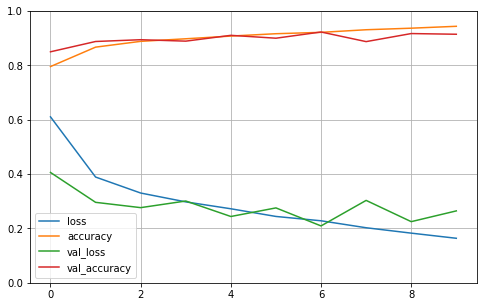

In [52]:
pd.DataFrame(mymodel6.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

We can see that the adding a Batch Normalization layer did not affect our model significantly. Overall, the best performing model was the first model with Batch Normaliation combined with the other adjustments we made. Even though our fully connected model has a slightly higher accuracy, its loss is also higher. 

Overall, we can see an improvment to our model both im accuracy and genrealizability by making various changes in regularization and hyperparameter tuning.